## Instalando as bibliotecas

In [ ]:
from qrcode_reader import show_qrcode_detected
% pip install numpy matplotlib scikit-image cv2

## Importando bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, filters, feature
from scipy import ndimage
import cv2
import os

### Carregando a imagem

In [16]:
DATASET_DIRECTORY = 'dataset'
IMAGE_NAME = '85705393.png'

image_path = os.path.join(DATASET_DIRECTORY, IMAGE_NAME)

image = io.imread(image_path)

if image.shape[-1] == 4:
    image = image[:,:,:3] # Removendo o canal alpha

image_gray = color.rgb2gray(image)
image_numpy = np.array(image_gray)


### Localizando o local do QR Code na imagem

#### Funções auxiliares

In [17]:
def encontrar_bbox(img_numpy, tollerance=5):

    linhas, colunas = np.where(img_numpy == 0)  # Pega as coordenadas dos pixels pretos

    if len(linhas) == 0 or len(colunas) == 0:
        return None

    # Determina os extremos da bounding box
    y_min, y_max = linhas.min(), linhas.max()
    x_min, x_max = colunas.min(), colunas.max()

    # Adicionando tolerância
    y_min, y_max = y_min - tollerance, y_max + tollerance
    x_min, x_max = x_min - tollerance, x_max + tollerance

    return x_min, y_min, x_max, y_max

def show_qrcode_detected(bbox, img):
    x_min, y_min, x_max, y_max = bbox
    return img[y_min:y_max, x_min:x_max]

def binarize_image(img, limiar=128):
    return (image > limiar).astype(int)  # Converte para 1 (branco) e 0 (preto)

#### Recortando o qr code na imagem

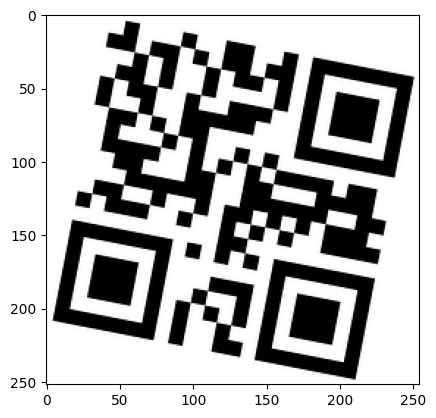

In [18]:
bbox = encontrar_bbox(image_numpy)

bbox_image = show_qrcode_detected(bbox, image_numpy)

plt.imshow(bbox_image, cmap='gray')
plt.show()
plt.imsave('qrcode_detected.png', bbox_image, cmap='gray')

### Função implementação canny

In [20]:
def gaussian_blur(image, sigma=1):
    return ndimage.gaussian_filter(image, sigma)

def sobel_filters(image):
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = ndimage.convolve(image, Kx)
    Iy = ndimage.convolve(image, Ky)

    G = np.hypot(Ix, Iy)  # magnitude
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)  # direção do gradiente

    return G, theta

def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # 0 graus
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # 45 graus
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # 90 graus
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                # 135 graus
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M, N = image.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(image >= highThreshold)
    weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

def canny(image, sigma=1, low_threshold=0.05, high_threshold=0.15):
    blurred = gaussian_blur(image, sigma)
    gradient_magnitude, gradient_direction = sobel_filters(blurred)
    suppressed = non_max_suppression(gradient_magnitude, gradient_direction)
    thresholded, weak, strong = threshold(suppressed, low_threshold, high_threshold)
    final = hysteresis(thresholded, weak, strong)
    return final

### Ajuste do ângulo da imagem

In [21]:
# Detecta as bordas com o Canny
# edges = filters.sobel(bbox_image) # Tentamos usar sobel, mas não foi eficaz
# edges = feature.canny(bbox_image, sigma=2.0)
edges = canny(bbox_image, sigma=2.0)

# Define um range de ângulos para testar (-45° a 45°)
tested_angles = np.linspace(-np.pi/4, np.pi/4, 100)

# Aplica a transformada de Hough para detectar linhas
h, theta, d = transform.hough_line(edges, theta=tested_angles)

# Seleciona os picos das linhas detectadas
accums, angles, dists = transform.hough_line_peaks(h, theta, d)

if len(angles) == 0:
    print("Nenhuma linha detectada. A rotação não pôde ser estimada.")
    rotation_angle = 0
else:
    # Estima o ângulo de rotação usando a mediana dos ângulos detectados
    rotation_angle = np.median(angles)

# Converte o ângulo para graus (para visualização e correção)
angle_deg = np.degrees(rotation_angle)
print("Ângulo detectado (em graus):", angle_deg)


# Corrige a rotação
corrected_image = transform.rotate(bbox_image, angle_deg, resize=False, cval=1.0)

Ângulo detectado (em graus): 11.363636363636367


### Realizando a rotação para ajustar os quadrados do QR Code

In [29]:
def detectar_quadrados_posicionais(img):
    h, w = img.shape
    metade_h, metade_w = h // 2, w // 2

    quadrantes = {
        "top_left": img[0:metade_h, 0:metade_w],
        "top_right": img[0:metade_h, metade_w:w],
        "bottom_left": img[metade_h:h, 0:metade_w],
        "bottom_right": img[metade_h:h, metade_w:w]
    }

    contagem_pretos = {k: np.sum(v < 128) for k, v in quadrantes.items()}

    return contagem_pretos

def estimar_rotacao_base_quadrantes(contagem):
    # Ordena pela quantidade de pixels pretos (decrescente)
    mais_escuros = sorted(contagem.items(), key=lambda item: item[1], reverse=True)

    nomes = [q[0] for q in mais_escuros[:3]]

    # Esperado: top_left, top_right, bottom_left
    if set(nomes) == {"top_left", "top_right", "bottom_left"}:
        if "top_left" in nomes and nomes[0] == "top_left":
            return 0
    elif set(nomes) == {"bottom_left", "bottom_right", "top_left"}:
        return 90
    elif set(nomes) == {"bottom_left", "bottom_right", "top_right"}:
        return 180
    elif set(nomes) == {"top_right", "top_left", "bottom_right"}:
        return 270

    return 0  # fallback

corrected_image_array = np.array(corrected_image)

contagem = detectar_quadrados_posicionais(corrected_image_array)
angulo = estimar_rotacao_base_quadrantes(contagem)

print(f"Rotação necessária: {angulo}°")
img_corrigida_final = transform.rotate(corrected_image, angulo, resize=False, cval=1.0)


Rotação necessária: 0°


### Recortando a imagem com a inclinação corrigida

In [25]:
img_final = show_qrcode_detected(encontrar_bbox(corrected_image), corrected_image)

### Exibindo os resultados

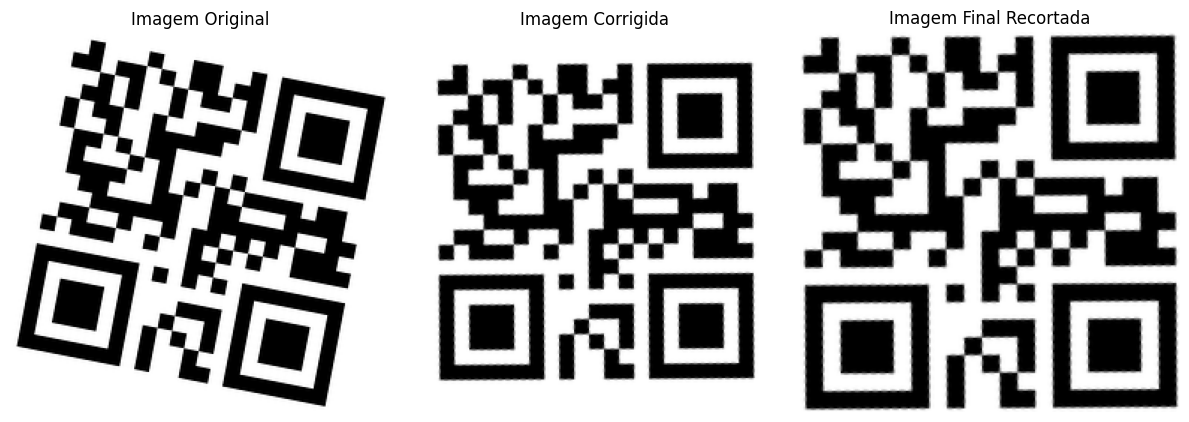

True

In [26]:
# Exibe a imagem original, a imagem com a correção de rotação e a imagem final recortada
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(bbox_image, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(corrected_image, cmap='gray')
axes[1].set_title('Imagem Corrigida')
axes[1].axis('off')

axes[2].imshow(img_final, cmap='gray')
axes[2].set_title('Imagem Final Recortada')
axes[2].axis('off')

plt.tight_layout()
plt.show()
corrected_image_uint8 = (img_final * 255).astype(np.uint8)


cv2.imwrite('qrcode_detected_rotated.png',corrected_image_uint8)

